# Consulta BQ
 
* PVO 
* Facturación

In [ ]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

if False: 
    client = bigquery.Client()
    consulta = """
        # Consulta PVO por ubicación
        with table_pvo as(
        SELECT
        FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS MesAnio,
        nom_grupo AS NombreGrupo,
        nom_direccion AS NombreDireccion,
        nom_subdireccion AS NombreSubdireccion,
        nom_familia_asociada as nom_familia_asociada,
        nom_ubicacion as nom_ubicacion,   # agregamos dato
        nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
        nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
        nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
        nom_articulo as nom_articulo,
        sum(toneladas_pvo) as toneladas_pvo,
        sum(toneladas_dim_capacidades) as toneladas_dim_capacidades,
        sum(toneladas_plan_ventas) as toneladas_plan_ventas,
        sum(toneladas_presupuesto) as toneladas_presupuesto
        FROM `datahub-deacero.mart_comercial.comercial` 
        where
        -- Descartamos los siguientes campos
        NombreGrupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS') --AND NombreDireccion NOT IN ('EXPORTACIÓN ALAMBRES')
        AND
        NombreSubdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
        AND
        NombreGrupoEstadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','SEGUNDAS') #'PALANQUILLA'
        AND
        NombreGrupoEstadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
        AND
        NombreGrupoEstadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','PILOTES','PISO','POLIZAS') #'DERECHO DE VIA'
    -- Necesitamos que la informacion no sea nula
        AND NombreGrupo IS NOT NULL
        AND NombreDireccion IS NOT NULL
        AND NombreSubdireccion IS NOT NULL
        AND NombreGrupoEstadistico1 IS NOT NULL
        AND NombreGrupoEstadistico2 IS NOT NULL
        AND NombreGrupoEstadistico3 IS NOT NULL
        AND nom_articulo IS NOT NULL
        and nom_ubicacion IS NOT NULL
        GROUP BY
        MesAnio,
        NombreGrupo,
        NombreDireccion,
        NombreSubdireccion,
        nom_ubicacion,
        nom_familia_asociada,
        NombreGrupoEstadistico1,
        NombreGrupoEstadistico2,
        NombreGrupoEstadistico3,
        nom_articulo
        )
        select * from table_pvo
        where DATE(MesAnio) >= DATE_TRUNC(CURRENT_DATE(), MONTH) 
        order by MesAnio, 
        NombreGrupo, 
        NombreDireccion, 
        NombreSubdireccion,
        nom_ubicacion,
        nom_familia_asociada,
        nom_articulo
            """
    query = client.query(consulta)
    pvo = query.to_dataframe(create_bqstorage_client=True)
    pvo.to_csv(r".\consultas\pvo.csv", index=False)

In [ ]:
if False: 
    client = bigquery.Client()
    consulta = """
    # Generación de Consulta GE3-SUBDIR-PL
    with table_fact AS (
    with data_base AS (
    SELECT
    FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS MesAnio,
    nom_grupo AS NombreGrupo,
    nom_direccion AS NombreDireccion,
    nom_subdireccion AS NombreSubdireccion,
    nom_ubicacion as nom_ubicacion,
    nom_familia_asociada as nom_familia_asociada,
    nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
    nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
    nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
    nom_articulo AS nom_articulo,
    toneladas_facturadas AS Toneladas_Facturadas
    FROM `datahub-deacero.mart_comercial.comercial` 
    WHERE EXTRACT(YEAR FROM fecha) >= 2024
    AND nom_gerencia NOT IN ('ACERIAS SPOT')
    )
    # Agregar un cambio de valores para los cuales Toneladas_Facturas es 0 si el valor original es negativo
    SELECT 
    data_base.MesAnio,
    data_base.NombreGrupo,
    data_base.NombreDireccion,
    data_base.NombreSubdireccion,
    data_base.nom_ubicacion,
    data_base.nom_familia_asociada,
    data_base.NombreGrupoEstadistico1,
    data_base.NombreGrupoEstadistico2,
    data_base.NombreGrupoEstadistico3,
    data_base.nom_articulo,
    SUM(data_base.Toneladas_Facturadas) AS Toneladas_Facturadas
    FROM data_base
    WHERE 
    -- Descartamos los siguientes campos
    NombreGrupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS') --AND NombreDireccion NOT IN ('EXPORTACIÓN ALAMBRES')
    AND
    NombreSubdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
    AND
    NombreGrupoEstadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','SEGUNDAS') #'PALANQUILLA'
    AND
    NombreGrupoEstadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
    AND
    NombreGrupoEstadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','PILOTES','PISO','POLIZAS') #'DERECHO DE VIA'
    -- Necesitamos que la informacion no sea nula
    AND NombreGrupo IS NOT NULL
    AND NombreDireccion IS NOT NULL
    AND NombreSubdireccion IS NOT NULL
    AND NombreGrupoEstadistico1 IS NOT NULL
    AND NombreGrupoEstadistico2 IS NOT NULL
    AND NombreGrupoEstadistico3 IS NOT NULL
    AND nom_articulo IS NOT NULL
    and nom_ubicacion IS NOT NULL
    and Toneladas_Facturadas IS NOT NULL
    GROUP BY
    data_base.MesAnio,
    data_base.NombreGrupo,
    data_base.NombreDireccion,
    data_base.NombreSubdireccion,
    data_base.nom_ubicacion,
    data_base.nom_familia_asociada,
    data_base.NombreGrupoEstadistico1,
    data_base.NombreGrupoEstadistico2,
    data_base.NombreGrupoEstadistico3,
    data_base.nom_articulo
    )
    
    select * from table_fact
    where
    DATE(MesAnio) <= DATE_TRUNC(CURRENT_DATE(), MONTH)
    order by
    MesAnio,
    NombreGrupo,
    NombreDireccion,
    NombreSubdireccion,
    nom_ubicacion,  
    nom_familia_asociada,
    NombreGrupoEstadistico1,
    NombreGrupoEstadistico2,
    NombreGrupoEstadistico3,
    nom_articulo
    """
    query = client.query(consulta)
    fact = query.to_dataframe(create_bqstorage_client=True)
    fact.to_csv(r".\consultas\fact.csv", index=False)

# Lectura de archivos de Sistema comercial

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib
from datetime import datetime
 
# ----------------------------------------------------
date = datetime.now().date()
# ----------------------------------------------------
m, y = date.month, date.year
# ----------------------------------------------------
min_date = date.replace(year= y-1, month = m, day = 1)
min_date_2 = date.replace(year= y-2, month = m, day = 1)
max_date = date.replace( month = m-1, day = 1) 
actual_date = date.replace(day = 1)
min_date, max_date, actual_date

(datetime.date(2024, 7, 1),
 datetime.date(2025, 6, 1),
 datetime.date(2025, 7, 1))

In [4]:
var= "toneladas_plan_ventas"
var2del = "toneladas_pvo"
pvo = pd.read_csv(r".\consultas\pvo.csv", engine="pyarrow")
pvo.nom_familia_asociada = pvo.nom_familia_asociada.str.replace(r'\s+|\t+', ' ', regex=True)
pvo.nom_ubicacion = pvo.nom_ubicacion.str.replace(r'\s+|\t+', ' ', regex=True)
pvo["Base"] = "pvo"
pvo = pvo.drop(columns= ["toneladas_dim_capacidades", var2del]) #"toneladas_pvo"
print(pvo.shape)
pvo = pvo.dropna(subset = [var, "nom_articulo", "nom_ubicacion"], how="any")
print(pvo.shape)
pvo["MesAct_fact"] = False

(1453880, 13)
(157498, 13)


In [5]:
fact = pd.read_csv(r".\consultas\fact.csv", engine="pyarrow")
fact.nom_familia_asociada = fact.nom_familia_asociada.str.replace(r'\s+|\t+', ' ', regex=True)
fact.nom_ubicacion = fact.nom_ubicacion.str.replace(r'\s+|\t+', ' ', regex=True)
fact["Base"] = "fact"
fact = fact[fact.MesAnio >= min_date_2]
fact["MesAct_fact"] = np.where( fact.MesAnio == actual_date, True, False)
fact.nom_familia_asociada = np.where(fact.nom_familia_asociada.isna(), fact.nom_articulo, fact.nom_familia_asociada) 
fact.MesAnio.nunique()

19

In [6]:
print("participación acomulada por familia asociada,  100 familias hacen el 99% del volumen")
# 120 familias tenemos el 95% de los registros
fact.nom_familia_asociada.value_counts(normalize=True).cumsum().head(120)
# 100 Familias hacen el 99% del volumen
vista_familias = (fact.groupby("nom_familia_asociada").Toneladas_Facturadas.sum().sort_values(ascending=False).cumsum() / fact.Toneladas_Facturadas.sum()).reset_index().head(100)
vista_familias

participación acomulada por familia asociada,  100 familias hacen el 99% del volumen


,nom_familia_asociada,Toneladas_Facturadas
0,(57) VARILLA LAM CALIENTE,0.342266
1,(55) ALAMBRON,0.491449
2,(236) ANGULO,0.550822
3,(238) VIGA,0.592131
4,(237) CANAL,0.633123
...,...,...
95,(361) SINKER NAIL,0.988244
96,(321) CRIBA GRANO DE PLATA REFORZADA,0.988695
97,(426) ALAMBRE CUADRADO,0.989143
98,(154) CLAVO C/C ANILLADO/ROLADO,0.989579


In [7]:
# Agrupamos por familia y ubicacion (pl)
fam_pl = fact.groupby(["nom_familia_asociada", "nom_ubicacion", "MesAnio"])["Toneladas_Facturadas"].sum().reset_index()
fam_pl["id"] = fam_pl.nom_familia_asociada + "_" + fam_pl.nom_ubicacion
pvo["id"] = pvo.nom_familia_asociada + "_" + pvo.nom_ubicacion
fam_pl.id.nunique() # 1944 combinaciones de pl & familias

2346

facturacion por mes volumen total


<Axes: xlabel='MesAnio'>

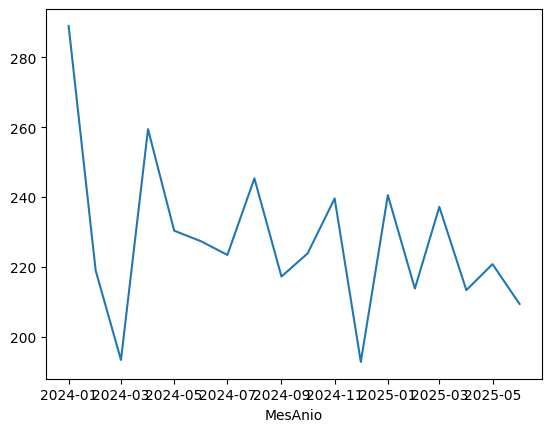

In [8]:
print("facturacion por mes volumen total")
# Facturación por familia y Ubicación
fam_pl.groupby("MesAnio").Toneladas_Facturadas.sum()[:-1].div(1000).plot()

## Analisis Familia PL

In [9]:
print("Existe un total de {} familias y ubicaciones".format(fam_pl.id.nunique()))
print("Existe un total de {} familias".format(fam_pl.nom_familia_asociada.nunique()))
print("Existe un total de {} ubicaciones".format(fam_pl.nom_ubicacion.nunique()))

Existe un total de 2346 familias y ubicaciones
Existe un total de 240 familias
Existe un total de 136 ubicaciones


In [10]:
print(fam_pl.shape[0])
fam_pl_f =  fam_pl[fam_pl.Toneladas_Facturadas>0]
print(fam_pl_f.shape[0])
fam_pl_f =  fam_pl[fam_pl.Toneladas_Facturadas>0]

kpi2 = fam_pl_f.groupby("id").agg({"MesAnio":["min", "max"]})
kpi2.columns = ["fecha_inicio", "fecha_fin"]
kpis = fam_pl_f.groupby("id").agg({ "nom_familia_asociada": "count", "Toneladas_Facturadas":"mean"}).rename(columns = {"nom_familia_asociada": "mcc", "Toneladas_Facturadas": "ton_media"} )
kpis = kpis.merge(kpi2, left_index=True, right_index=True)
kpis["r_ton_med"] = pd.qcut(kpis.ton_media, q = 4, labels = [1,2,3,4])
kpis["r_mcc_med"] = pd.qcut(kpis.ton_media, q = 4,  labels = [1,2,3,4])
kpis.fecha_inicio = pd.to_datetime(kpis.fecha_inicio) 
kpis.fecha_fin = pd.to_datetime(kpis.fecha_fin) 
kpis["qdate"] = kpis.fecha_inicio.dt.year.mul(100) + kpis.fecha_inicio.dt.quarter
kpis["qdate"]= np.where(kpis.fecha_inicio.dt.year < 2024, kpis.fecha_inicio.dt.year.mul(100), kpis["qdate"] )
kpis["msc"] = kpis.fecha_fin.max() - kpis.fecha_fin
kpis["msc"] = kpis["msc"].dt.days.div(30).round(0)
kpis["r_msc"] = pd.cut(kpis.msc, bins = [-np.inf, 1, 2, 3, 4, 8 , 10,12, np.inf], labels = [1,2,3,4,8, 10, 12, 13] )
#kpis["Q"] =  kpis.fecha_inicio.dt.quarter

def freq(x): 
    # pandas time series
    x = x[x.Toneladas_Facturadas > 0]
    if x.shape[0]< 2 :
        return None
    else:  
        x = round(x.MesAnio.diff().mean().days / 30) 
        return x
    
base = fam_pl.reset_index().groupby(["MesAnio", "id"]).Toneladas_Facturadas.sum().reset_index()
base.MesAnio = pd.to_datetime(base.MesAnio)
base_gb = base.groupby("id")
calculo_frecuencia_media = base_gb.apply(lambda x :  freq(x))
calculo_frecuencia_media = calculo_frecuencia_media.reset_index().rename(columns = {0: "Freq"})
kpis = kpis.reset_index().merge(calculo_frecuencia_media, on = "id")
kpis["Freq"] = kpis["Freq"].fillna(24)
kpis ["r_freq"] = pd.cut(x = kpis.Freq, bins = [0, 1,2,3,6,9,12, np.inf], labels = [1,2,3,6,9,12,13])

# Calculo de Trimestre que se tienen transacciones PL & FAMILIA
import re
fam_pl.MesAnio = pd.to_datetime(fam_pl.MesAnio)
fam_pl_q = fam_pl.groupby(["id", fam_pl.MesAnio.dt.quarter]).Toneladas_Facturadas.sum().reset_index().sort_values(by = ["id", "MesAnio"], ascending=[True, True])
fam_pl_q = fam_pl_q.sort_values(by = "MesAnio", ascending=False) 
fam_pl_q.MesAnio =  fam_pl_q.MesAnio.astype(str) 
fam_pl_q = fam_pl_q.groupby("id").MesAnio.unique().apply(lambda x: re.sub(r'\D', '', str(set(x)))).reset_index()
kpis = kpis.merge(fam_pl_q,on = "id", how="left").rename(columns = {"MesAnio": "Q"})
kpis["len_Q"] = kpis.Q.apply(lambda x: len(x))
kpis["Q"] = kpis.Q.astype(int)

kpis["var_mcc_4_or_less"] = np.where(kpis.mcc < 5, True, False)

display(kpis.sample(10))

print(" Analisis de Cuando Arrancan los ids 2024 -2025")
kpis = kpis.sort_values(by = "qdate")
display(pd.DataFrame(pd.crosstab(kpis.qdate, kpis.r_mcc_med, normalize=True).T.sum()).T.style.format("{:.2%}"))
pd.crosstab(kpis.qdate, kpis.r_mcc_med, margins = True).T

22329
21170


C:\Users\adojeda\AppData\Local\Temp\ipykernel_4908\3802369630.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calculo_frecuencia_media = base_gb.apply(lambda x :  freq(x))


,id,mcc,ton_media,fecha_inicio,fecha_fin,r_ton_med,r_mcc_med,qdate,msc,r_msc,Freq,r_freq,Q,len_Q,var_mcc_4_or_less
1237,(55) ALAMBRON_CHICAGO DC,10,174.400110,2024-04-01,2025-05-01,4,4,202402,2.0,2,1.0,1,1324,4,False
1925,(FA) - GRADUADA HORSE FENCE_MACROHUB BAJIO,4,1.692500,2025-02-01,2025-06-01,2,2,202501,1.0,1,1.0,1,12,2,True
1204,(54) ALAMBRE PULIDO INDUSTRIAL_MACROHUB LAREDO,19,223.516358,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,1324,4,False
1309,(57) VARILLA LAM CALIENTE_PLANTA INGETEK MXL,15,68.113933,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,1324,4,False
249,(196) VALLA DEACERO_CEDI MERIDA,2,0.316000,2024-03-01,2024-05-01,1,1,202401,14.0,13,2.0,2,12,2,True
632,(280 - 3032) CADENA PULIDA DELGADA _CEDI CULIA...,15,0.126400,2024-01-01,2025-06-01,1,1,202401,1.0,1,1.0,1,1324,4,False
1837,(FA) - FIXED KNOT GALV Y ZA_ALAMBRES MÉXICO,18,3.522056,2024-01-01,2025-06-01,2,2,202401,1.0,1,1.0,1,1324,4,False
621,(280 - 284) CADENA GALV INMERSION GRUESA _CEDI...,2,0.175000,2024-06-01,2024-11-01,1,1,202402,8.0,8,5.0,6,24,2,True
1511,(FA) - ALAMBRE RECOCIDO BOBINERO_IND. LEÓN 1,17,92.916941,2024-02-01,2025-06-01,4,4,202401,1.0,1,1.0,1,1324,4,False
1510,(FA) - ALAMBRE RECOCIDO BOBINERO_ALAMBRES MÉXICO,19,275.233789,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,1324,4,False


 Analisis de Cuando Arrancan los ids 2024 -2025


qdate,202401,202402,202403,202404,202501,202502,202503
0,69.57%,8.78%,6.21%,3.82%,5.68%,5.68%,0.27%


qdate,202401,202402,202403,202404,202501,202502,202503,All
r_mcc_med,,,,,,,,
1,320,47,54,24,49,66,4,564
2,387,67,35,21,30,23,0,563
3,405,54,27,23,33,19,2,563
4,456,30,24,18,16,20,0,564
All,1568,198,140,86,128,128,6,2254


### Deacuerdo a todas las combinaciones de familia asociada & PL 
#### Rango de venta (r_mcc_med) vs Primer registro con transacción (qdate)

* 1568 tuvieron su primer movimiento en el 2024Q1 ~70%,
* el resto tuvieron primero movimiento en 2024Q2 o posterior ~30%

Esto quiere decir que posiblemente las series de tiempo no sean de consumo recurrente, la frecuencia de recompra por lo tanto podria influir en la demanda de los productos
#### Analisis de Frecuencia de reparto
Se procedió a calcular la frecuencia media de reparto como la distancia entre meses con consumo de tonelaje mayor que 0, luego promedio.


In [11]:
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.r_mcc_med, normalize=True).T.sum()).T.style.format("{:.2%}"))
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.r_mcc_med, values= kpis.ton_media, aggfunc= "sum",  normalize=True).T.sum()).T.style.format("{:.2%}"))
pd.crosstab(kpis.r_freq, kpis.r_mcc_med, margins = True).T

r_freq,1,2,3,6,9,12,13
0,60.87%,13.75%,4.92%,3.90%,1.06%,0.49%,15.00%


r_freq,1,2,3,6,9,12,13
0,84.14%,9.69%,0.84%,0.61%,0.14%,0.01%,4.57%


r_freq,1,2,3,6,9,12,13,All
r_mcc_med,,,,,,,,
1,245,90,39,38,6,3,143,564
2,311,94,29,23,6,6,94,563
3,366,68,29,20,9,2,69,563
4,450,58,14,7,3,0,32,564
All,1372,310,111,88,24,11,338,2254


* 1372 combinaciones tienen demanda mensual ~ 60%
* 310 combinaciones tienen demanda bimestral ~13%
* 338  combinaciones tienen demanda anual o one-shot ~15% 
* el 10% de las combiaciones tienen demanda trimestral o semestral

esto quiere decir que:  
* si tomamos una ventana de tiempo de analisis de 3 meses podriamos encontrar el  73% de las combinaciones en nuestros pronosticos,
* para evitar un sesgo se recomienda tener una ventana de analisis que ajuste al 95% de las observacionees (1Y)  **5%** del volumen bias

## Analisis de Trimestes vs Frecuencia de reparto

Endeguida se procedió a calcular en cuantos Q's se tienen transaccioes [Q1, Q2, Q3, Q4], se usa la cantidad de trimestres y se comparara con los meses con compra para encontrar el punto medio de 


<Axes: xlabel='len_Q', ylabel='r_freq'>

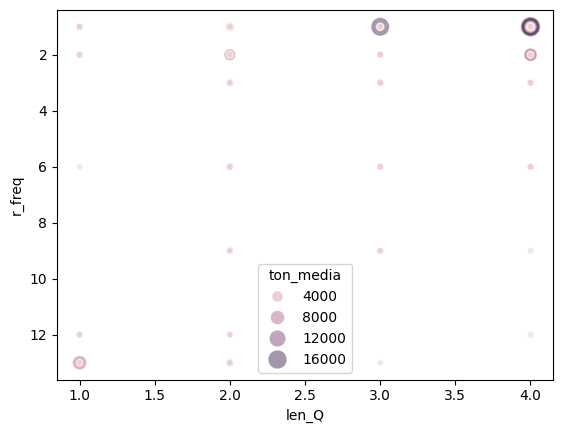

In [14]:
import seaborn as sns
sns.scatterplot(kpis, x = "len_Q", y = "r_freq", size = "ton_media", hue = "ton_media", sizes=(20, 200), alpha=0.5)

In [12]:
kpis = kpis.sort_values(by = "len_Q", ascending=False)
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.len_Q, normalize=True).sum()).T.style.format("{:.2%}"))
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.len_Q, normalize=True)).style.format("{:.2%}"))
display(pd.DataFrame(pd.crosstab(kpis.r_freq, kpis.len_Q, values= kpis.ton_media, aggfunc= "sum", normalize=True)).style.format("{:.2%}"))
pd.crosstab(kpis.r_freq, kpis.len_Q, margins = True)

len_Q,1,2,3,4
0,21.34%,14.77%,11.14%,52.75%


len_Q,1,2,3,4
r_freq,,,,
1,7.32%,5.81%,4.04%,43.70%
2,0.58%,2.40%,3.55%,7.23%
3,0.00%,1.38%,2.35%,1.20%
6,0.04%,2.35%,0.98%,0.53%
9,0.00%,0.84%,0.18%,0.04%
12,0.18%,0.27%,0.00%,0.04%
13,13.22%,1.73%,0.04%,0.00%


len_Q,1,2,3,4
r_freq,,,,
1,0.91%,3.27%,7.68%,72.28%
2,0.02%,2.18%,0.64%,6.86%
3,0.00%,0.34%,0.30%,0.20%
6,0.00%,0.48%,0.10%,0.03%
9,0.00%,0.08%,0.04%,0.02%
12,0.00%,0.01%,0.00%,0.00%
13,4.26%,0.31%,0.00%,0.00%


len_Q,1,2,3,4,All
r_freq,,,,,
1,165,131,91,985,1372
2,13,54,80,163,310
3,0,31,53,27,111
6,1,53,22,12,88
9,0,19,4,1,24
12,4,6,0,1,11
13,298,39,1,0,338
All,481,333,251,1189,2254


el 52.5% de las combinacioes se compran en los 4 trimestreas , de ellas solo el 43% del total corresponde a pedidos mensuales y **7.5%** bimestrales, sin embargo estas combinaciones corresponden al **72%** del volumen total facturado

listado de indicadores: 
* ton_media: toneladas promedio por mes (se excluyen ceros y valores negativos)
* msc: meses sin compra
* Freq : Frecuencia de Entrega
* Q : Trimestre con compra ej, 1234 : Q1,Q2,Q3,Q4...
* len_Q : cantidad de trimestres con compra
* var_mcc_4_or_less: con almenos 4 meses con compra (facturacion )

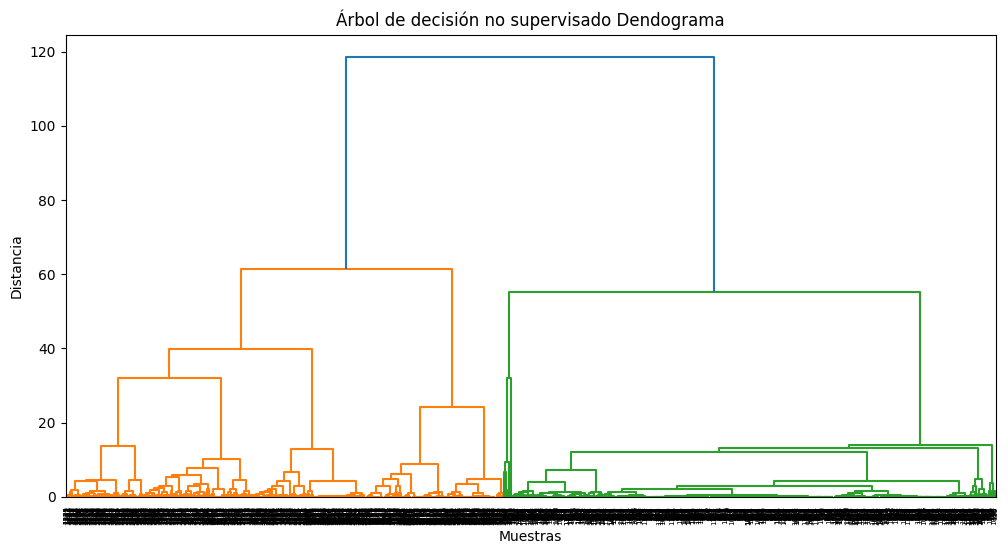

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

columnas = ['ton_media', 'msc', 'Freq', 'Q', 'len_Q', "var_mcc_4_or_less"]
df_numerico = kpis[columnas]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numerico)

# Clustering jerárquico
linked = linkage(X_scaled, method='ward')

# Dendrograma
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Árbol de decisión no supervisado Dendograma')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

In [19]:
from scipy.cluster.hierarchy import fcluster

from scipy.stats import f_oneway

f_c = fcluster(linked, t=50, criterion='distance')
kpis['cluster'] = f_c
X_scaled_df =pd.DataFrame(X_scaled, columns=columnas)
X_scaled_df['cluster'] = f_c

print(kpis['cluster'].value_counts())


anova_results = {}

for var in columnas:
    groups = [group[var].values for name, group in X_scaled_df.groupby('cluster')]
    f_stat, p_val = f_oneway(*groups)
    anova_results[var] = {'F-statistic': f_stat, 'p-value': p_val}

# Convertir resultados a DataFrame ordenado por F-statistic
anova_df = pd.DataFrame(anova_results).T.sort_values(by='F-statistic', ascending=False)
anova_df



cluster
1    1174
4     727
3     334
2      19
Name: count, dtype: int64


,F-statistic,p-value
Q,84058.013797,0.000000e+00
Freq,26192.099410,0.000000e+00
len_Q,4694.994441,0.000000e+00
var_mcc_4_or_less,1792.330998,0.000000e+00
ton_media,1620.976966,0.000000e+00
msc,532.788190,1.436304e-261


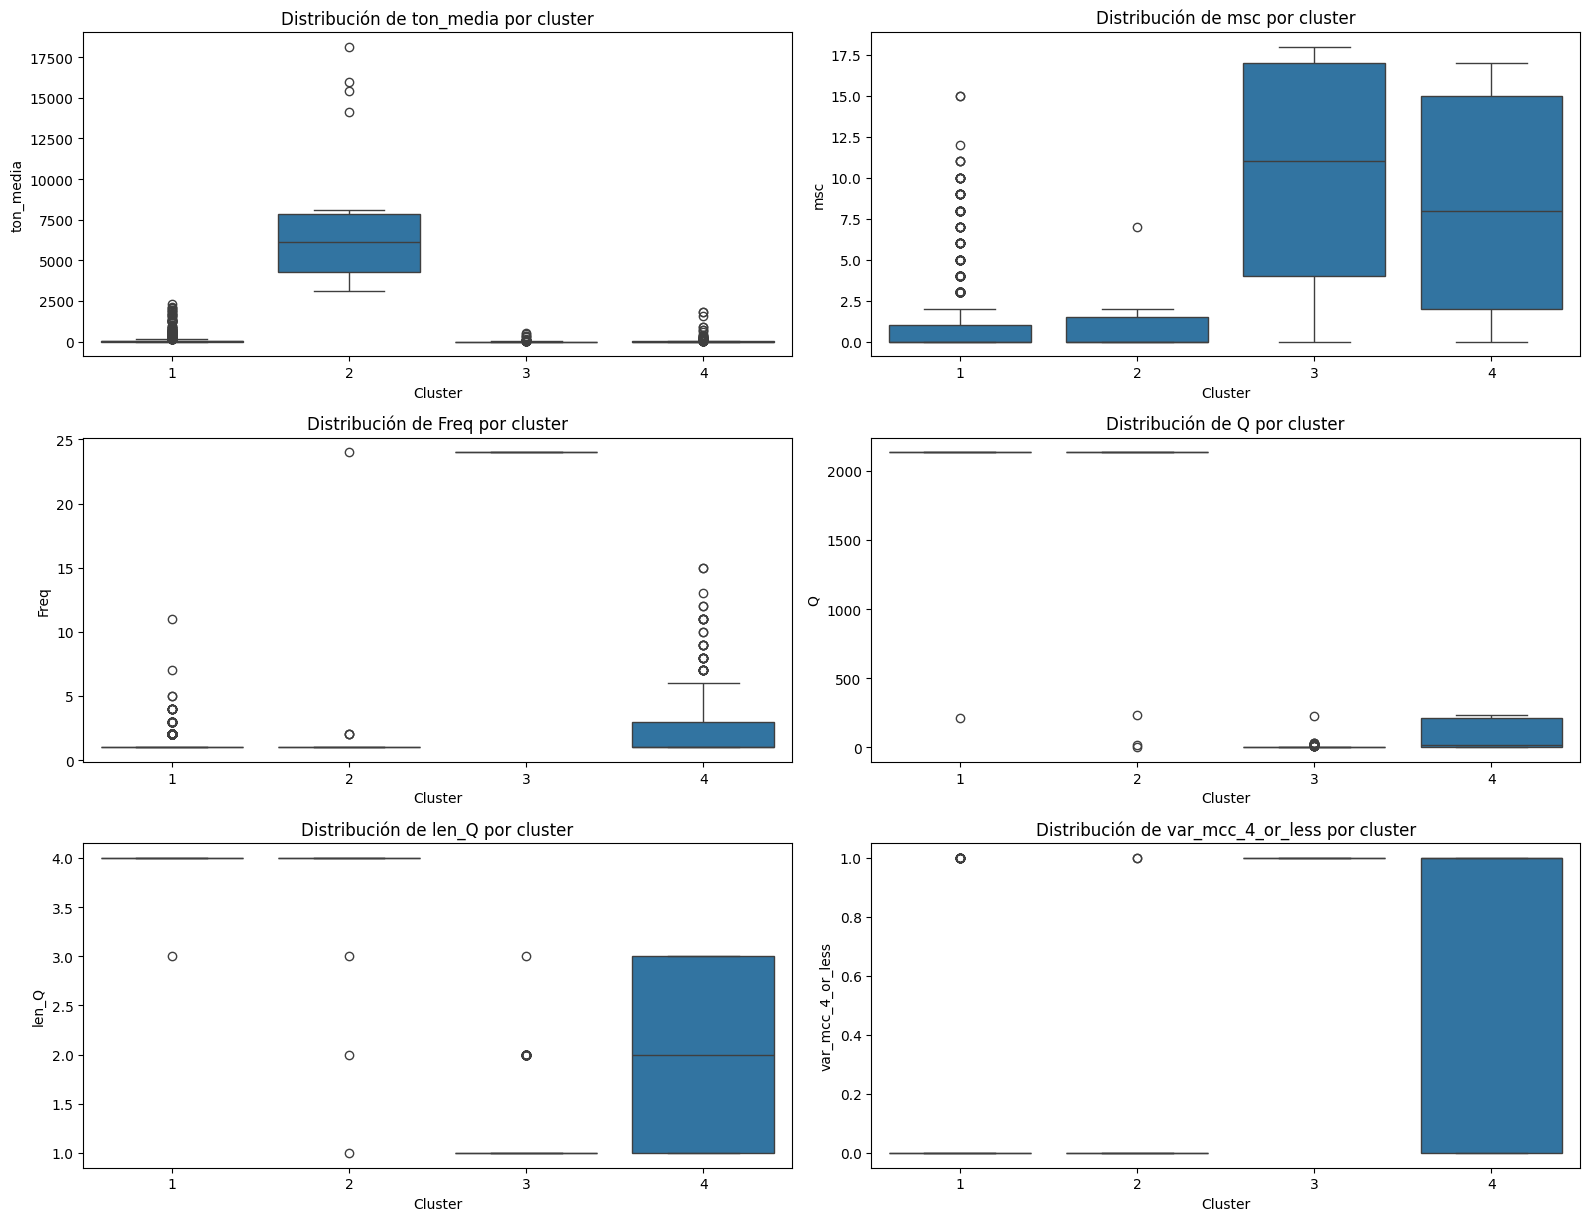

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear gráficos de caja para cada variable por cluster
plt.figure(figsize=(16, 20))
for i, var in enumerate(columnas, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x='cluster', y=var, data=kpis)
    plt.title(f'Distribución de {var} por cluster')
    plt.xlabel('Cluster')
    plt.ylabel(var)

plt.tight_layout()
plt.show()



In [ ]:
kpis.groupby("cluster").agg({i:["count","median", "mean"]  for i in columnas[:-3]})

ton_media                             msc                    Freq  \
            count       median         mean count median       mean count   
cluster                                                                     
1            1174    10.352089    95.745417  1174    0.0   1.155026  1174   
2              19  6156.568777  7567.035290    19    0.0   0.894737    19   
3             334     1.506000    14.273339   334   11.0  10.146707   334   
4             727     2.872500    31.835064   727    8.0   8.451169   727   

                           
        median       mean  
cluster                    
1          1.0   1.229131  
2          1.0   2.368421  
3         24.0  24.000000  
4          1.0   2.236589

con estas variables generamos 4 clusters: 

* **1** Cluster con 1174 combinaciones, tonelaje medio 10 ton, hasta 2 meeses sin compra y frecuencia mensual o bimestral, compra todos los Q's
* **2** Cluster con 19 combinaciones (mas importantes) alta demanda en volumen 6000 toneladas, frecuencia mensual o bimestral compa todos los Q's
* **3** Cluster con 334 combinaciones media de 1.5 toneladas, con hasta 1 año sin compra o frecuencia anual compra solo en 1 Q.
* **4** Cluster con 727 combinaciones, media de 3 toneladas con hasta 8 meses sin compra y frecuencia bimestral, trimestral o semestral, compra en almenos 2 Q's    
* **5** Cluter con aquellas combinaciones no etiquetadas (sin compra en el periodo de analisis) -Creacion de nueva ruta o bien nueva familia, familia re-actvada en 1 año y medio

## PVO

In [24]:
kpis.cluster.value_counts()

cluster
1    1174
4     727
3     334
2      19
Name: count, dtype: int64

In [25]:
kpis[kpis.cluster == 2].sort_values(by = "ton_media", ascending=False)

,id,mcc,ton_media,fecha_inicio,fecha_fin,r_ton_med,r_mcc_med,qdate,msc,r_msc,Freq,r_freq,Q,len_Q,var_mcc_4_or_less,cluster
1208,(55) ALAMBRON_ACERÍA CELAYA,19,18151.517883,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,2
1287,(57) VARILLA LAM CALIENTE_CEDI VIRTUAL ACERIA ...,19,15944.772407,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,2
1366,(67) PALANQUILLA_ACERÍA CELAYA,7,15421.952857,2024-06-01,2024-12-01,4,4,202402,7.0,8,1.0,1,234,3,False,2
1255,(57) VARILLA LAM CALIENTE_ACERÍA CELAYA,19,14110.356645,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,2
1369,(67) PALANQUILLA_PUERTO VERACRUZ,1,8122.330000,2025-06-01,2025-06-01,4,4,202502,1.0,1,24.0,13,2,1,True,2
428,(236) ANGULO_ACERÍA RAMOS ARIZPE,19,7584.015768,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,2
1311,(57) VARILLA LAM CALIENTE_PUERTO MAZATLAN,9,6931.913556,2024-02-01,2025-06-01,4,4,202401,1.0,1,2.0,2,2134,4,False,2
1209,(55) ALAMBRON_ACERÍA SALTILLO,19,6890.826252,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,2
1289,(57) VARILLA LAM CALIENTE_CEDI VIRTUAL MERIDA ...,12,6224.739937,2024-01-01,2025-07-01,4,4,202401,0.0,1,2.0,2,2134,4,False,2
479,(238) VIGA_ACERÍA RAMOS ARIZPE,19,6156.568777,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,2


In [26]:
kpis[kpis.cluster == 1].sample(20).sort_values(by = "ton_media", ascending=False)

,id,mcc,ton_media,fecha_inicio,fecha_fin,r_ton_med,r_mcc_med,qdate,msc,r_msc,Freq,r_freq,Q,len_Q,var_mcc_4_or_less,cluster
1319,(60 - 63) STAR STUCCO 20 _MACROHUB LAREDO,19,309.444439,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,1
1528,(FA) - CASTILLO EN HOJA DEACERO_ALAMBRES CELAYA,11,108.569727,2024-01-01,2025-06-01,4,4,202401,1.0,1,2.0,2,2134,4,False,1
1105,(500) MALLA INGENIERIA ITK_CEDI GARCIA,9,65.683778,2024-01-01,2025-03-01,4,4,202401,4.0,4,2.0,2,2134,4,False,1
1206,(54) ALAMBRE PULIDO INDUSTRIAL_MEXICALI WCDC,17,58.284289,2024-03-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,1
421,(235) SOLERA_GASTONIA DC,7,49.178143,2024-02-01,2024-09-01,4,4,202401,10.0,10,1.0,1,2134,4,False,1
2125,(FA) - PUAS CORCEL Y VAQUERO_MACROHUB NORTE,19,44.697874,2024-01-01,2025-07-01,4,4,202401,0.0,1,1.0,1,2134,4,False,1
974,(442) DSS DIRECT DRAWN WIRE_CEDI CULIACAN,13,28.417308,2024-06-01,2025-06-01,3,3,202402,1.0,1,1.0,1,2134,4,False,1
1858,(FA) - GAVIONES_ALAMBRES FINOS,7,27.074429,2024-01-01,2025-04-01,3,3,202401,3.0,3,3.0,3,2134,4,False,1
783,(36) CLAVO SINKER_MEXICALI WCDC,15,20.013379,2024-05-01,2025-07-01,3,3,202402,0.0,1,1.0,1,2134,4,False,1
2115,(FA) - PUAS CORCEL Y VAQUERO_CEDI CULIACAN,18,14.862333,2024-01-01,2025-06-01,3,3,202401,1.0,1,1.0,1,2134,4,False,1


In [27]:
kpis[kpis.cluster == 3].sample(20).sort_values(by = "ton_media", ascending=False)

,id,mcc,ton_media,fecha_inicio,fecha_fin,r_ton_med,r_mcc_med,qdate,msc,r_msc,Freq,r_freq,Q,len_Q,var_mcc_4_or_less,cluster
452,(236) ANGULO_PUERTO VERACRUZ,1,158.420000,2025-06-01,2025-06-01,4,4,202502,1.0,1,24.0,13,2,1,True,3
473,(237) CANAL_NORTH CAROLINA DC,1,40.224000,2024-03-01,2024-03-01,4,4,202401,16.0,13,24.0,13,21,2,True,3
434,(236) ANGULO_CEDI DALLAS,1,19.778785,2025-06-01,2025-06-01,3,3,202502,1.0,1,24.0,13,2,1,True,3
1474,(FA) - ALAMBRE GALV HOUSTON_MACROHUB LAREDO,1,19.608000,2025-05-01,2025-05-01,3,3,202502,2.0,2,24.0,13,2,1,True,3
2076,(FA) - MULTIMALLA MARINA_ALAMBRES PUEBLA,1,18.013000,2025-02-01,2025-02-01,3,3,202501,5.0,8,24.0,13,1,1,True,3
1130,(508) 2D&3D ITK H_MACROHUB NORTE,1,9.510000,2025-03-01,2025-03-01,3,3,202501,4.0,4,24.0,13,1,1,True,3
1842,(FA) - FIXED KNOT GALV Y ZA_CALIFORNIA SUR DC,1,7.146000,2025-05-01,2025-05-01,3,3,202502,2.0,2,24.0,13,2,1,True,3
294,(208) BARRERAS DE CABLES_ALAMBRES MÉXICO,1,5.229000,2025-06-01,2025-06-01,3,3,202502,1.0,1,24.0,13,2,1,True,3
710,(320) CRIBA GRANO DE PLATA LIGERA_CALIFORNIA S...,1,2.098000,2025-02-01,2025-02-01,2,2,202501,5.0,8,24.0,13,1,1,True,3
213,(170 - 5060) GRAPA SOD _MACROHUB NORTE,1,2.008000,2024-02-01,2024-02-01,2,2,202401,17.0,13,24.0,13,1,1,True,3


In [28]:
kpis[kpis.cluster == 4].sample(20).sort_values(by = "ton_media", ascending=False)

,id,mcc,ton_media,fecha_inicio,fecha_fin,r_ton_med,r_mcc_med,qdate,msc,r_msc,Freq,r_freq,Q,len_Q,var_mcc_4_or_less,cluster
506,(2400 - 12570) ALAMBRE GALV. ALTO CARBONO INVE...,5,70.950800,2024-09-01,2025-03-01,4,4,202403,4.0,4,2.0,2,134,3,False,4
1637,(FA) - CICLONICA GALV DEACERO 69_CEDI TIJUANA,3,55.703000,2024-01-01,2024-03-01,4,4,202401,16.0,13,1.0,1,1,1,True,4
1321,(6056 - 12311) ALAMBRE ELECTROGALV GRUESOS_ALA...,8,55.533375,2024-04-01,2025-06-01,4,4,202402,1.0,1,2.0,2,214,3,False,4
409,(235) SOLERA_BIRMINGHAM DC,8,42.471125,2024-01-01,2024-09-01,4,4,202401,10.0,10,1.0,1,231,3,False,4
271,(199) TORON DE PRE-ESFUERZO USA_ALAMBRES PUEBLA,2,33.869500,2025-02-01,2025-03-01,4,4,202501,4.0,4,1.0,1,1,1,True,4
2142,(FA) - RECOCIDOS INDUSTRIALES_CEDI CHIAPAS EXP...,3,26.937333,2024-01-01,2024-04-01,3,3,202401,15.0,13,2.0,2,231,3,True,4
1428,(FA) - ALAMBRE COLCHONERO > 16 (GUSANILLO)_GAS...,5,21.454800,2024-01-01,2025-02-01,3,3,202401,5.0,8,3.0,3,231,3,False,4
1620,(FA) - CICLONICA GALV DEACERO 63_MACROHUB LAREDO,2,19.062000,2024-01-01,2024-07-01,3,3,202401,12.0,12,6.0,6,231,3,True,4
932,(42) CRIMP WIRE_MACROHUB LAREDO,7,16.253571,2024-01-01,2024-08-01,3,3,202401,11.0,12,1.0,1,231,3,False,4
377,(233) CUADRADO_BIRMINGHAM DC,2,11.553500,2024-04-01,2024-06-01,3,3,202402,13.0,13,2.0,2,2,1,True,4


In [29]:
cluster2_pvo = pvo[pvo.id.isin(kpis[kpis.cluster == 2].id)]
cluster2_pvo["MesAnio"] = pd.to_datetime(cluster2_pvo.MesAnio)
cluster2_pvo= cluster2_pvo.groupby(["MesAnio", "id"]).toneladas_plan_ventas.sum().unstack(-1)
cluster2_pvo["tipo"] = "pvo"
cluster2_pvo

C:\Users\adojeda\AppData\Local\Temp\ipykernel_12884\723080978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster2_pvo["MesAnio"] = pd.to_datetime(cluster2_pvo.MesAnio)


id,(236) ANGULO_ACERÍA RAMOS ARIZPE,(236) ANGULO_B. USA VTS DIR,(237) CANAL_ACERÍA RAMOS ARIZPE,(237) CANAL_B. USA VTS DIR,(238) VIGA_ACERÍA RAMOS ARIZPE,(55) ALAMBRON_ACERÍA CELAYA,(55) ALAMBRON_ACERÍA SALTILLO,(57) VARILLA LAM CALIENTE_ACERÍA CELAYA,(57) VARILLA LAM CALIENTE_ACERÍA RAMOS ARIZPE,(57) VARILLA LAM CALIENTE_B. USA VTS DIR,(57) VARILLA LAM CALIENTE_CEDI HOUSTON-GULFSTR,(57) VARILLA LAM CALIENTE_CEDI VIRTUAL ACERIA CELAYA INGETEK,(57) VARILLA LAM CALIENTE_CEDI VIRTUAL MERIDA INGETEK,(57) VARILLA LAM CALIENTE_PATIO MERIDA,(57) VARILLA LAM CALIENTE_PATIO PUEBLA,(57) VARILLA LAM CALIENTE_PUERTO MAZATLAN,tipo
MesAnio,,,,,,,,,,,,,,,,,
2025-07-01,14295.541230,3033.33314,10021.905630,3052.873090,14941.193270,20481.055710,11861.950670,28366.636990,19007.393330,2001.601470,0.0,13426.698600,4041.953650,3375.321410,13520.421530,8000.00001,pvo
2025-08-01,14878.288338,3249.32712,10583.394782,3244.904173,11811.315874,17552.644157,11833.218371,29133.995258,19463.662748,2001.861429,0.0,13306.372760,5065.915245,3372.243272,14759.781927,NaN,pvo
2025-09-01,14995.384196,3249.32712,10447.993875,3244.904173,11681.351582,16338.534031,11843.887553,27615.431981,19725.660610,2001.971071,0.0,13101.044043,5065.915245,3369.943835,14109.895977,8000.00000,pvo
2025-10-01,14203.624680,2828.68129,9672.966600,2824.924700,12373.951990,16368.071550,11886.806300,29047.538150,19769.888690,2000.000040,0.0,13122.933720,5389.271540,3369.025420,14036.760100,0.00000,pvo
2025-11-01,13810.892860,2676.08350,9392.458560,2672.159910,13609.055620,16661.428120,11932.788470,29703.460160,20243.808690,2003.047040,0.0,13603.854700,5389.271540,3784.389960,14496.583220,8010.43181,pvo
2025-12-01,13275.739840,2544.20424,8420.150680,2410.044180,13528.306990,16236.056840,10116.761150,30010.273340,19567.933760,2003.047040,NaN,12963.737010,5389.271540,3699.832780,13810.903670,NaN,pvo


In [ ]:
cluster2_venta = fam_pl[fam_pl.id.isin(kpis_f[kpis_f.cluster.isin([1,4])].id)]
cluster2_venta = cluster2_venta.groupby(["MesAnio", "id"]).Toneladas_Facturadas.sum().unstack(-1).fillna(0)
cluster2_venta["tipo"] = "venta"

cluster_2 = pd.concat([cluster2_venta, cluster2_pvo])
cluster_2
cluster_2 = cluster_2[~((cluster_2.index == "2025-07-01") &	(cluster_2.tipo == "venta"))]

,MesAnio,id,value,tipo
0,2024-01-01,(236) ANGULO_ACERÍA RAMOS ARIZPE,9126.10500,Real
1,2024-02-01,(236) ANGULO_ACERÍA RAMOS ARIZPE,6503.82000,Real
2,2024-03-01,(236) ANGULO_ACERÍA RAMOS ARIZPE,6363.97900,Real
3,2024-04-01,(236) ANGULO_ACERÍA RAMOS ARIZPE,7294.78335,Real
4,2024-05-01,(236) ANGULO_ACERÍA RAMOS ARIZPE,9002.18594,Real


(236) ANGULO_ACERÍA RAMOS ARIZPE 


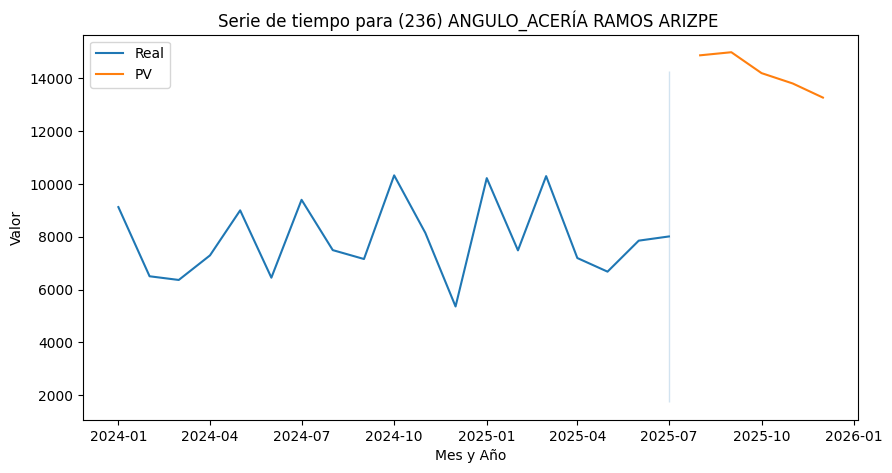

(236) ANGULO_B. USA VTS DIR 


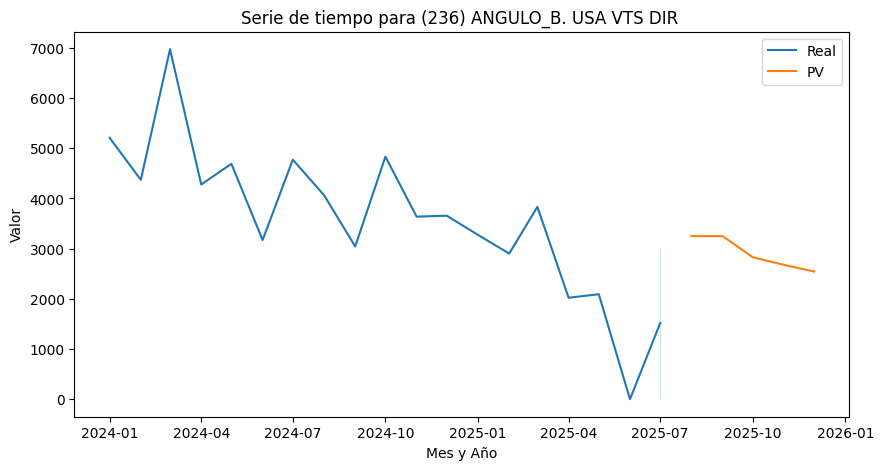

(237) CANAL_ACERÍA RAMOS ARIZPE 


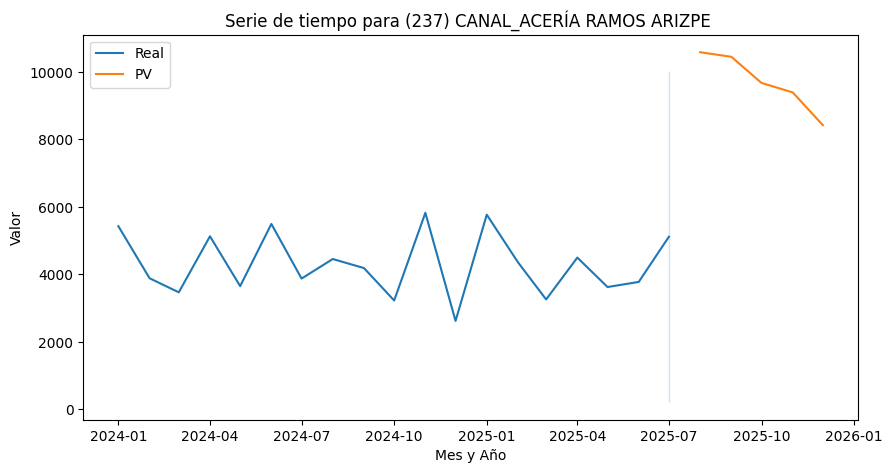

(237) CANAL_B. USA VTS DIR 


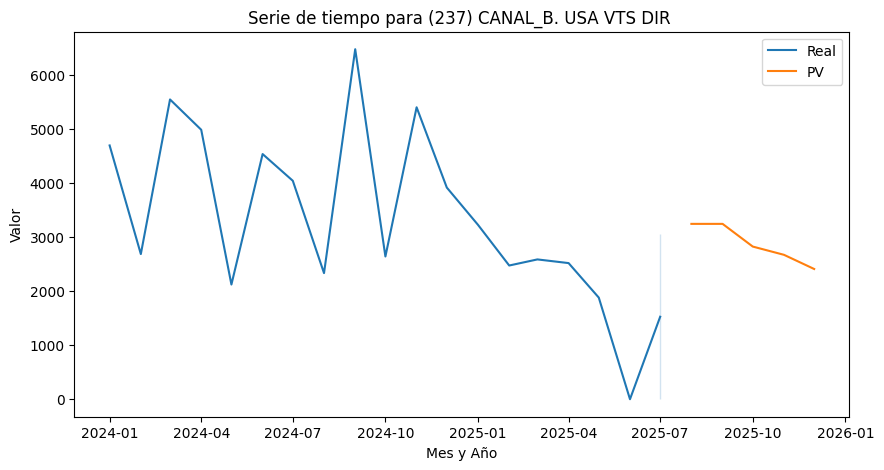

(238) VIGA_ACERÍA RAMOS ARIZPE 


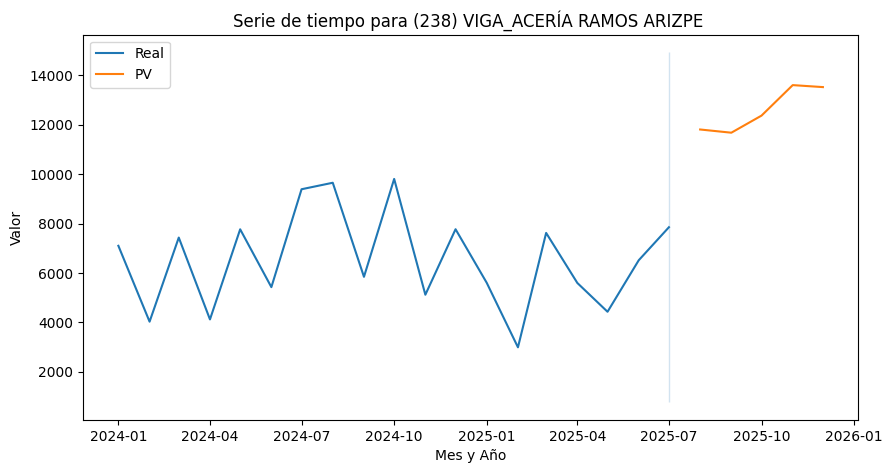

(55) ALAMBRON_ACERÍA CELAYA 


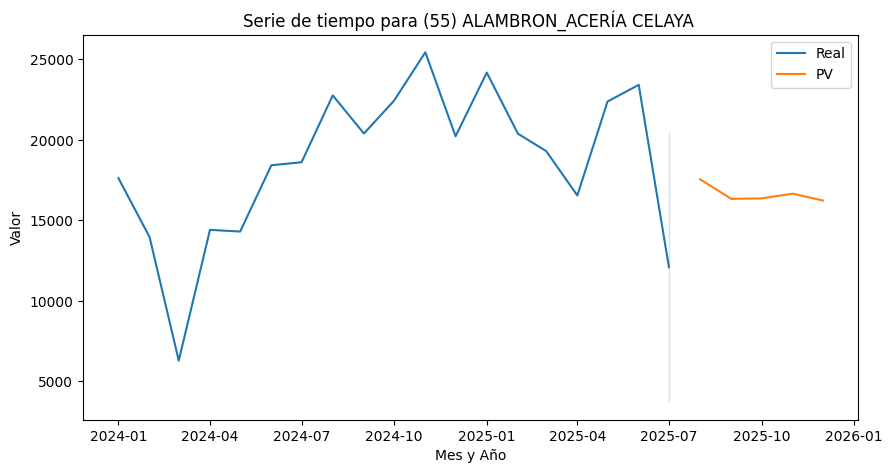

(55) ALAMBRON_ACERÍA SALTILLO 


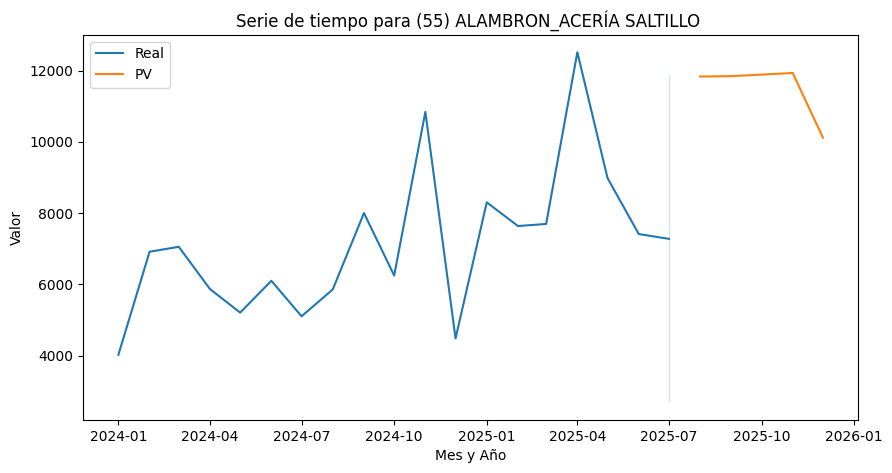

(57) VARILLA LAM CALIENTE_ACERÍA CELAYA 


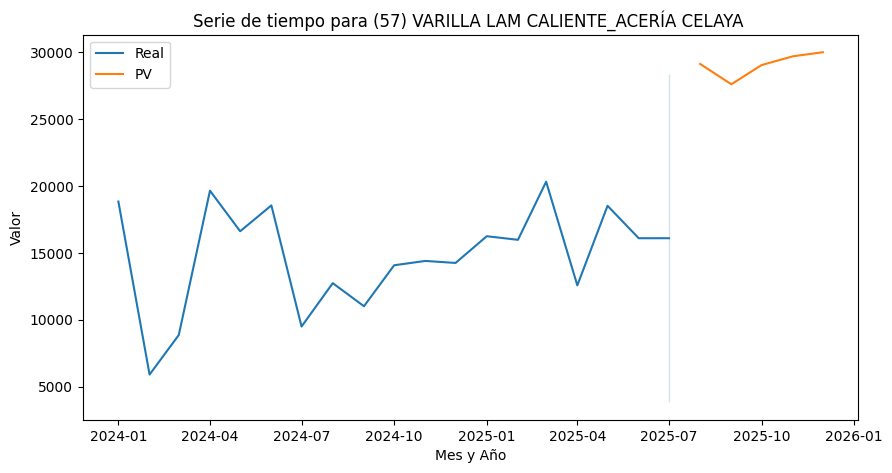

(57) VARILLA LAM CALIENTE_ACERÍA RAMOS ARIZPE 


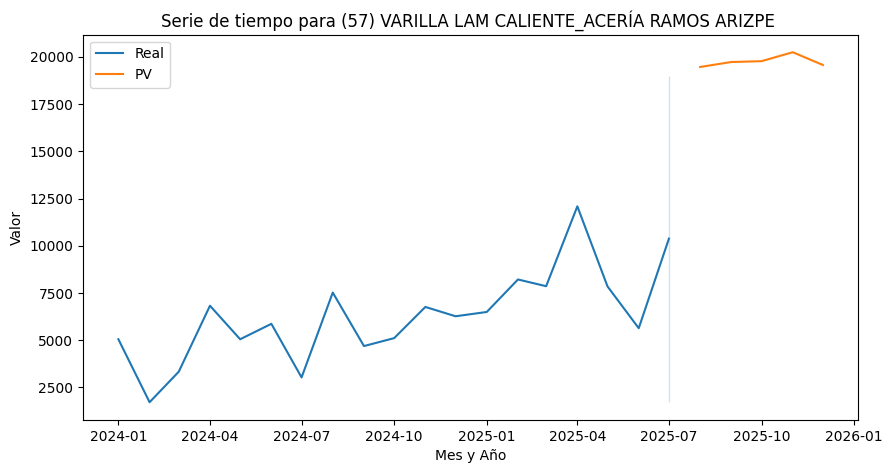

(57) VARILLA LAM CALIENTE_B. USA VTS DIR 


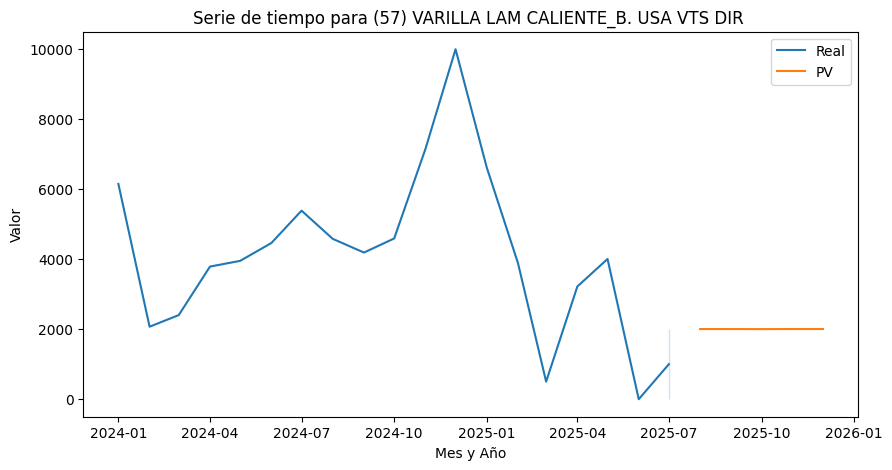

(57) VARILLA LAM CALIENTE_CEDI HOUSTON-GULFSTR 


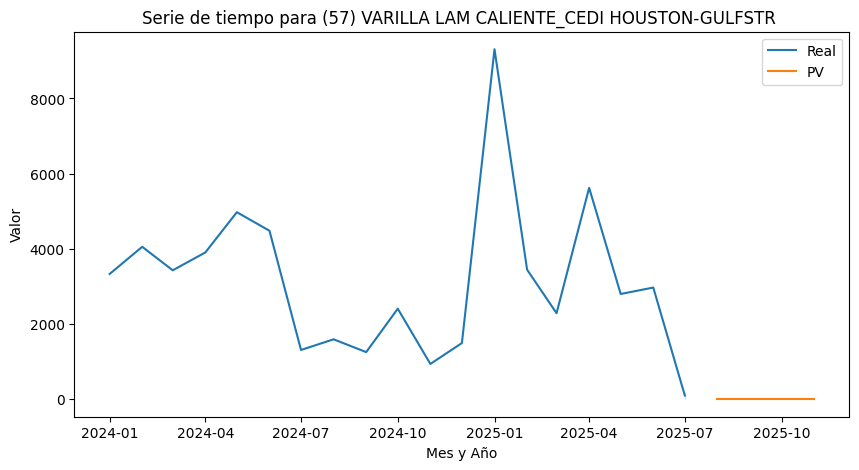

(57) VARILLA LAM CALIENTE_CEDI VIRTUAL ACERIA CELAYA INGETEK 


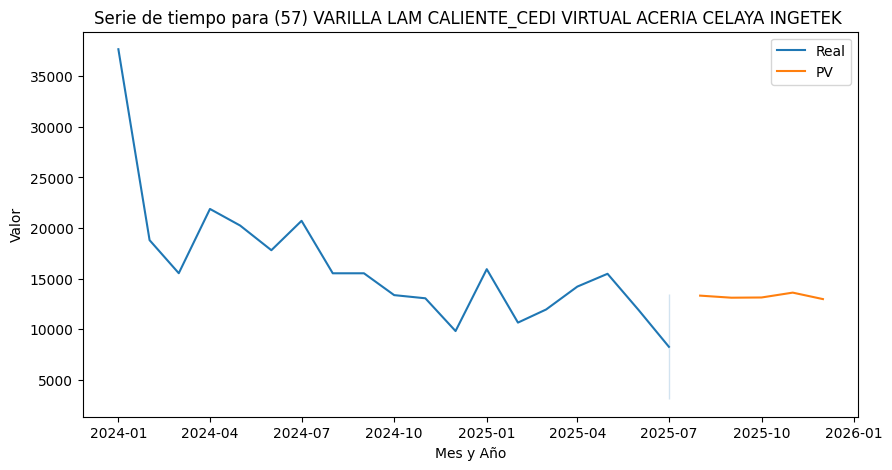

(57) VARILLA LAM CALIENTE_CEDI VIRTUAL MERIDA INGETEK 


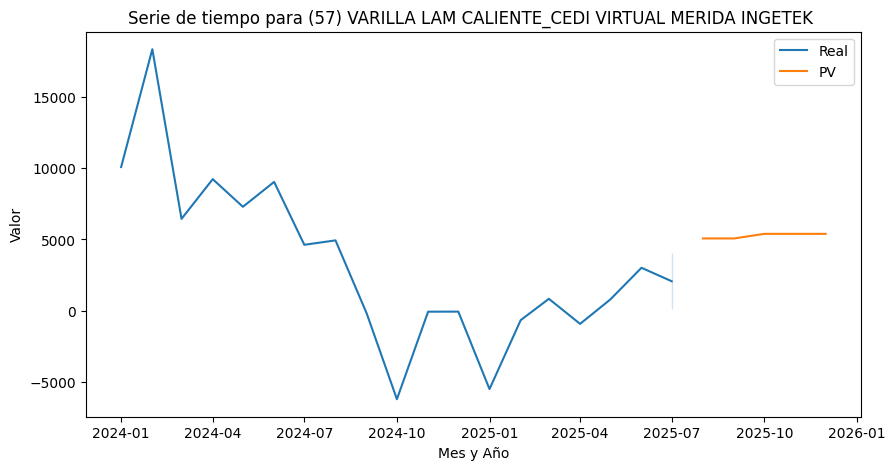

(57) VARILLA LAM CALIENTE_PATIO MERIDA 


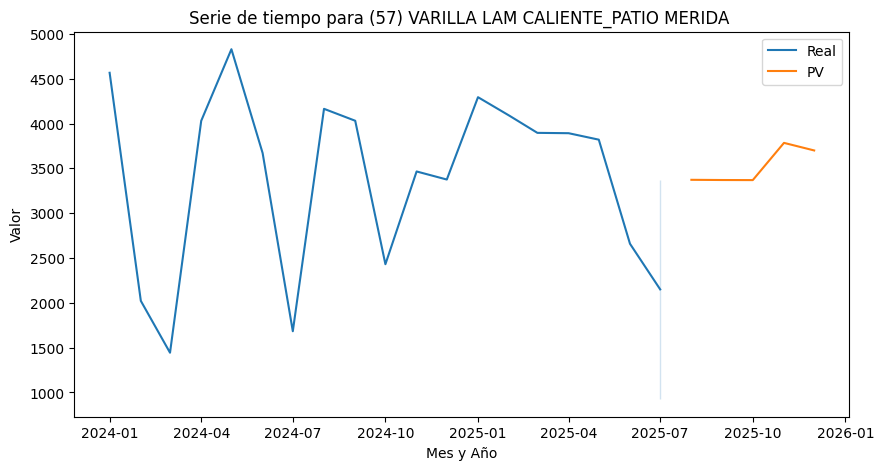

(57) VARILLA LAM CALIENTE_PATIO PUEBLA 


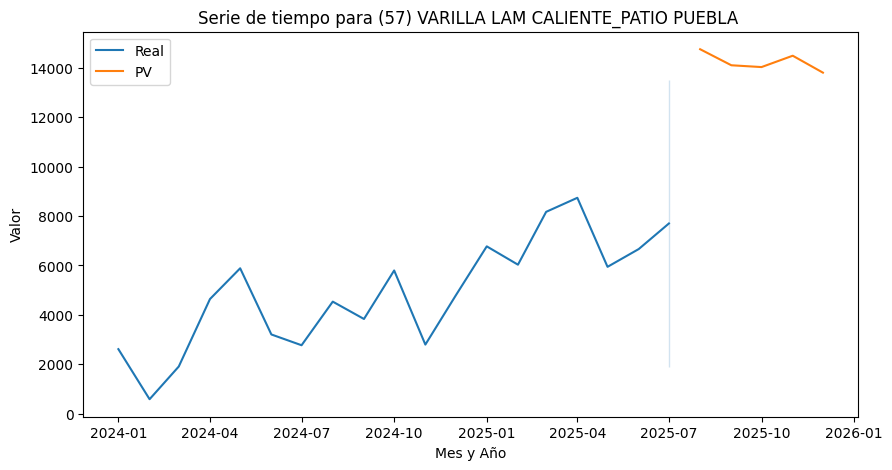

(57) VARILLA LAM CALIENTE_PUERTO MAZATLAN 


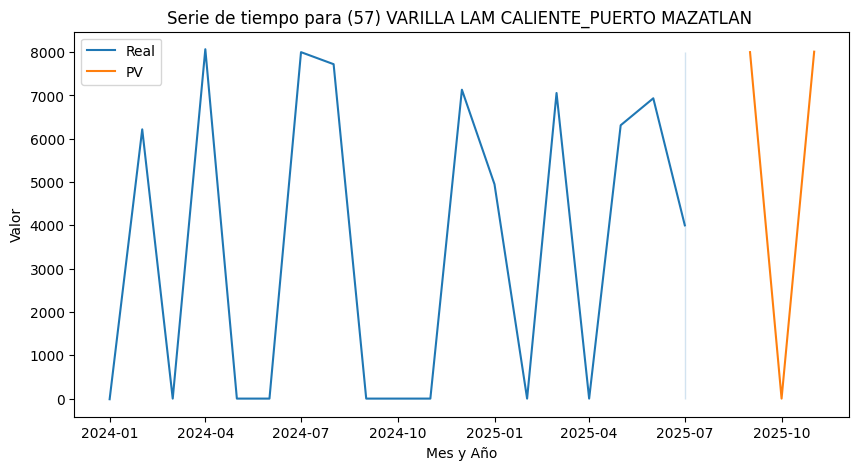

(67) PALANQUILLA_ACERÍA CELAYA 


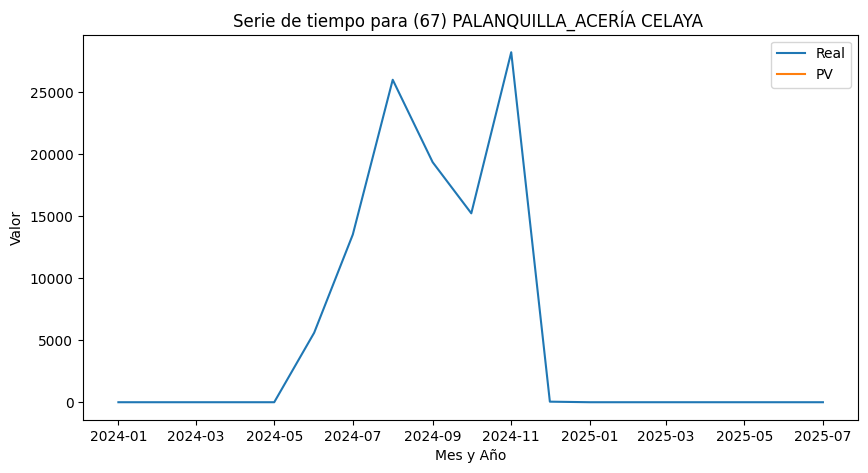

(67) PALANQUILLA_PUERTO MAZATLAN 


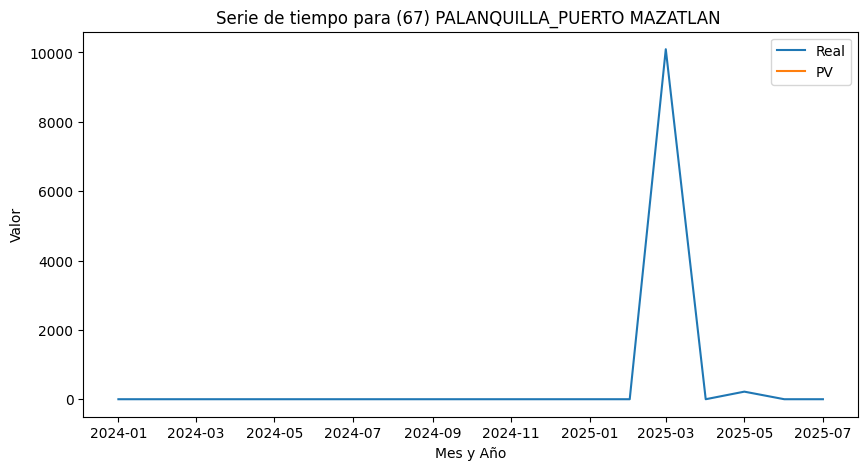

(67) PALANQUILLA_PUERTO VERACRUZ 


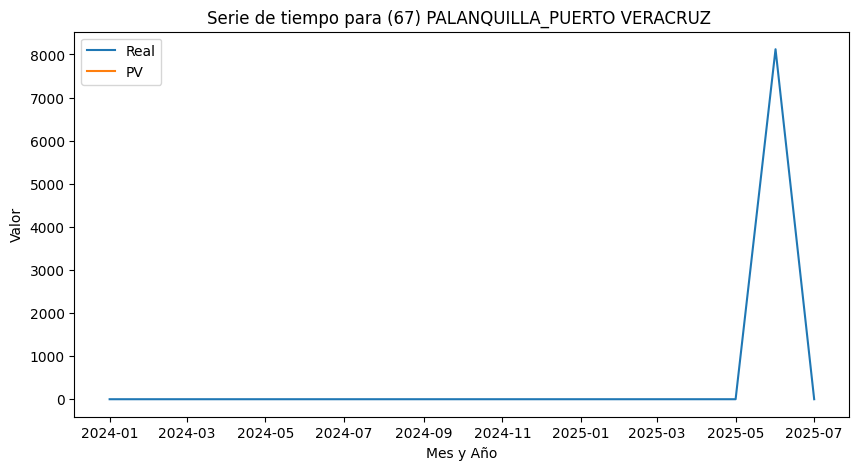

In [33]:
X_ = pd.melt(cluster_2.drop(columns = "tipo"), ignore_index= False).reset_index()
X_["tipo"] = np.where(X_.MesAnio > "2025-07-01","PV", "Real")
display(X_.head())

for i in X_.id.unique():
    print(i)
    X_i = X_[X_.id == i]
    plt.figure(figsize=(10, 5))
    sns.lineplot(X_i, x = "MesAnio", y = "value", hue = "tipo")
    plt.title(f"Serie de tiempo para {i}")
    plt.xlabel("Mes y Año")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()


In [ ]:
def mr(x):
    serie = [x[i] -  for i in x if i > 0]